# Delivery Time Analysis

**Introduction**

Predicting accurate delivery times is key to running our grocery service well. Our current system just uses one average time for everything. But, we think things like where we're delivering (houses vs. apartments) matter.

This report looks at our past delivery data (orders, products, routes) to find patterns that explain why delivery times change. We want to see if we can find trends similar to the house vs. apartment idea, even without that specific info.

What we learn here will help us build smarter prediction tools, so we can give better delivery estimates and keep our customers happy.

**(Full analysis code available in the linked Jupyter Notebook.)**

The full code used for this analysis is available in jupyter notebook in the github repository: https://github.com/mjuzek22/Monika_Juzek_Data_Krakow.

## Data Loading and Initial Inspection

In this section, we will connect to our MySQL database containing the historical delivery information and load the relevant tables into pandas DataFrames using Python. The tables we will be accessing are:

* `orders`: Contains information about individual orders, including order IDs, customer IDs, sector IDs, and planned delivery durations.
* `products`: Details the products available, including their unique IDs and weights.
* `orders_products`: Links orders to the products they contain, along with the quantity of each product.
* `route_segments`: Provides information about the segments of each delivery route, including driver IDs, segment types (DRIVE or STOP), associated order IDs (for stops), and segment start and end times.

Once the data is loaded, we will inspect the first few rows of each DataFrame and obtain a summary of their structure and data types. This initial exploration will help us understand the contents of each table and identify the key columns that will be crucial for our subsequent analysis.

In [5]:
# Load data into DataFrames
orders_df = pd.read_sql('SELECT * FROM orders', engine)
products_df = pd.read_sql('SELECT * FROM products', engine)
orders_products_df = pd.read_sql('SELECT * FROM orders_products', engine)
route_segments_df = pd.read_sql('SELECT * FROM route_segments', engine)

In [9]:
#Verify the DataFrames:

print("orders_df:")
print(orders_df.head())  # Show the first 5 rows of the orders DataFrame
print(orders_df.describe())
print("products_df:")
print(products_df.head())  # Show the first 5 rows of the products DataFrame
print(products_df.describe())
print("orders_products_df:")
print(orders_products_df.head())  # Show the first 5 rows of the orders_products DataFrame
print(orders_products_df.describe())
print("route_segments_df:")
print(route_segments_df.head())  # Show the first 5 rows of the route_segments DataFrame
print(route_segments_df.describe())

orders_df:
   order_id  customer_id  sector_id  planned_delivery_duration
0         0          116          1                        176
1         1          160          1                        169
2         2           94          2                        177
3         3          165          3                        176
4         4           78          2                        177
          order_id  customer_id    sector_id  planned_delivery_duration
count  2240.000000  2240.000000  2240.000000                 2240.00000
mean   1119.500000   161.483482     2.017857                  176.88750
std     646.776623    92.169624     0.819941                    4.96543
min       0.000000     0.000000     1.000000                  169.00000
25%     559.750000    84.750000     1.000000                  175.00000
50%    1119.500000   161.000000     2.000000                  176.00000
75%    1679.250000   245.000000     3.000000                  177.00000
max    2239.000000   319.000000    

## Calculating Actual Delivery Duration

To determine the actual time taken for each delivery, we need to analyze the `route_segments` data. Each delivery event is marked by segments where the `segment_type` is 'STOP'. Our initial approach considered summing the durations of all 'STOP' segments associated with a single `order_id`. However, if an `order_id` appears multiple times with the `segment_type` as 'STOP', it could indicate complexities in the data or delivery process that require closer examination.

Therefore, our revised strategy involves the following steps:

1.  **Identify STOP Segments:** We will first filter the `route_segments` table to isolate all segments where the `segment_type` is 'STOP'.
2.  **Calculate Segment Durations:** For each of these 'STOP' segments, we will calculate the duration by finding the difference between the `segment_end_time` and `segment_start_time`.
3.  **Address Multiple STOP Segments per Order:** We will investigate orders that have more than one associated 'STOP' segment. By examining the timestamps and durations of these segments for the same `order_id`, we aim to understand the nature of these multiple stops. This will inform our decision on how to best represent the actual delivery duration for such orders. Potential approaches include considering the duration of the first stop, the last stop, the longest stop, the sum of durations, or identifying a primary delivery stop based on the time intervals between them.

Our immediate next step will be to identify and analyze the orders with multiple 'STOP' segments to gain a clearer understanding before deciding on a final method for calculating the actual delivery duration for each order.
The output is:

In [9]:
import pandas as pd


# Filter for STOP segments
stop_segments_df = route_segments_df[route_segments_df['segment_type'] == 'STOP'].copy()

# Convert timestamps to datetime objects
stop_segments_df['segment_start_time'] = pd.to_datetime(stop_segments_df['segment_start_time'])
stop_segments_df['segment_end_time'] = pd.to_datetime(stop_segments_df['segment_end_time'])

# Calculate the actual delivery duration in seconds
stop_segments_df['actual_delivery_duration'] = (stop_segments_df['segment_end_time'] - stop_segments_df['segment_start_time']).dt.total_seconds()

# Now, let's address the case of multiple STOP segments per order.
# The problem description suggests one key STOP segment per order for the delivery.
# Let's inspect if there are orders with multiple STOP segments.

multiple_stops_per_order = stop_segments_df.groupby('order_id').size().reset_index(name='stop_count')
orders_with_multiple_stops = multiple_stops_per_order[multiple_stops_per_order['stop_count'] > 1]

print(f"Number of orders with more than one STOP segment: {len(orders_with_multiple_stops)}")

if not orders_with_multiple_stops.empty:
    print("Order IDs with multiple STOP segments:")
    print(orders_with_multiple_stops['order_id'].tolist())
    print("\nLet's look at a few examples to understand why this might be happening:")
    print(stop_segments_df[stop_segments_df['order_id'].isin(orders_with_multiple_stops['order_id'].head().tolist())])

# Based on the problem description ("order_id - identifier of an order delivered in the segment (only when type = STOP)"),
# it's likely that each STOP segment corresponds to a unique delivery for that order.
# If there are multiple STOP segments for the same order_id, it might indicate:
# 1. Errors in the data partitioning.
# 2. The driver made multiple stops related to the same order (less likely for a single delivery).
# 3. Different interpretations of what constitutes a 'STOP' segment.

# Given the instruction, let's assume that for each order, we should consider all associated STOP segments
# and sum their durations to get the total actual delivery time for that order.

actual_delivery_duration_per_order = stop_segments_df.groupby('order_id')['actual_delivery_duration'].sum().reset_index()

# Merge this back with the orders_df to have the actual delivery duration alongside other order information
orders_with_actual_duration_df = pd.merge(orders_df, actual_delivery_duration_per_order, on='order_id', how='left')

print("\nFirst few rows of the orders data with calculated actual delivery duration:")
print(orders_with_actual_duration_df.head())

Number of orders with more than one STOP segment: 17
Order IDs with multiple STOP segments:
[158.0, 234.0, 244.0, 502.0, 513.0, 647.0, 788.0, 888.0, 989.0, 1297.0, 1529.0, 1551.0, 1699.0, 1822.0, 1896.0, 2029.0, 2112.0]

Let's look at a few examples to understand why this might be happening:
      segment_id  driver_id segment_type  order_id  segment_start_time  \
677          677          4         STOP     158.0 2024-02-24 14:44:13   
680          680          4         STOP     158.0 2024-02-24 14:39:53   
2620        2620          1         STOP     234.0 2024-02-16 14:19:29   
2622        2622          1         STOP     234.0 2024-02-16 14:19:29   
2628        2628          4         STOP     502.0 2024-02-11 14:56:47   
2630        2630          4         STOP     502.0 2024-02-11 14:56:47   
3181        3181          4         STOP     244.0 2024-02-11 14:59:58   
3183        3183          4         STOP     244.0 2024-02-11 14:59:58   
4468        4468          4         STOP 

Our investigation into orders with multiple 'STOP' segments revealed data quality issues, including negative durations (likely due to timestamp errors) and segments with zero duration (possibly duplicates or very short stops).

Our revised plan to calculate the actual delivery duration is:

1.  **Filter for 'STOP' segments.**
2.  **Convert timestamps to datetime objects.**
3.  **Calculate duration for each segment and discard those with non-positive durations.**
4.  **For each order, sum the durations of all its remaining (positive) 'STOP' segments.**
5.  **Merge this total duration with the `orders_df`.**

This approach aims to handle identified data errors while still assuming that all valid 'STOP' segments for an order contribute to the overall delivery time.

In [ ]:
# 1. Filter for STOP segments
stop_segments_df = route_segments_df[route_segments_df['segment_type'] == 'STOP'].copy()

# 2. Convert timestamps to datetime objects
stop_segments_df['segment_start_time'] = pd.to_datetime(stop_segments_df['segment_start_time'])
stop_segments_df['segment_end_time'] = pd.to_datetime(stop_segments_df['segment_end_time'])

# 3. Calculate the actual delivery duration
stop_segments_df['actual_delivery_duration'] = (stop_segments_df['segment_end_time'] - stop_segments_df['segment_start_time']).dt.total_seconds()

# 4. Filter out segments with non-positive actual delivery duration
positive_duration_stops_df = stop_segments_df[stop_segments_df['actual_delivery_duration'] > 0]

# 5. Aggregate by order_id and sum the durations of the positive duration stops
actual_delivery_duration_per_order = positive_duration_stops_df.groupby('order_id')['actual_delivery_duration'].sum().reset_index()

# 6. Merge with the orders_df
orders_with_actual_duration_df = pd.merge(orders_df, actual_delivery_duration_per_order, on='order_id', how='left')

print("First few rows of the orders data with actual delivery duration (negative durations removed):")
print(orders_with_actual_duration_df.head())

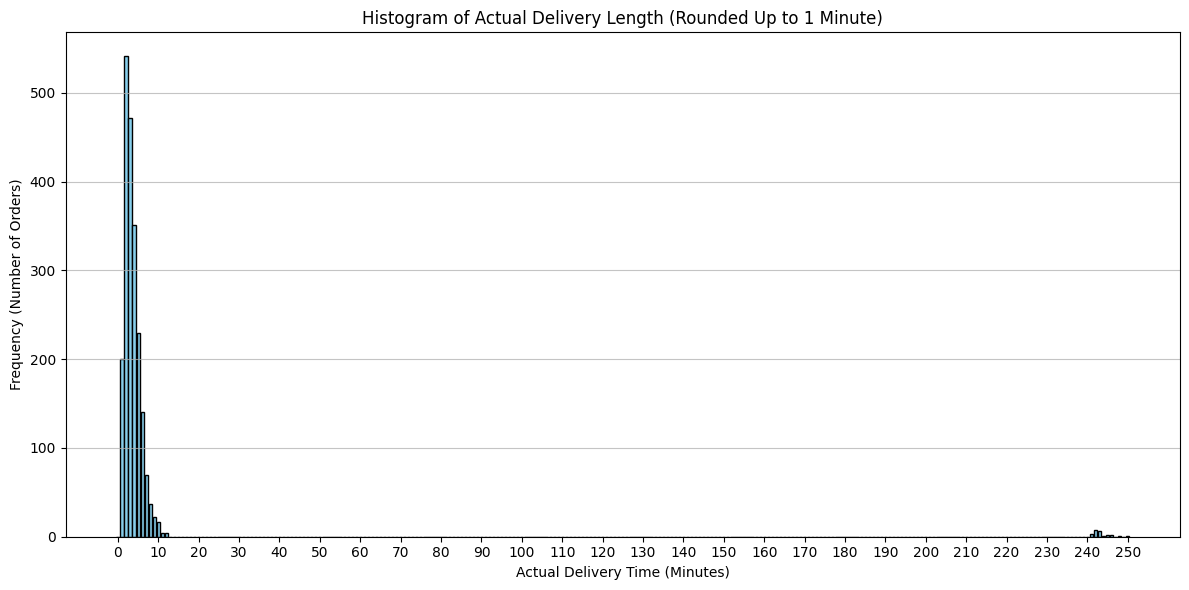

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure we have the actual delivery duration in minutes (rounded up)
if 'actual_delivery_duration' in orders_with_actual_duration_df.columns:
    orders_with_actual_duration_df['actual_delivery_duration_minutes'] = np.ceil(orders_with_actual_duration_df['actual_delivery_duration'] / 60)

    max_minutes = int(orders_with_actual_duration_df['actual_delivery_duration_minutes'].max())

    # Determine a reasonable interval for x-axis ticks
    if max_minutes > 60:
        tick_interval = 10
    elif max_minutes > 30:
        tick_interval = 5
    else:
        tick_interval = 2

    # Create the histogram
    plt.figure(figsize=(12, 6))
    plt.hist(orders_with_actual_duration_df['actual_delivery_duration_minutes'].dropna(),
             bins=range(max_minutes + 2),
             align='left',
             rwidth=0.8,
             color='skyblue',
             edgecolor='black')

    plt.title('Histogram of Actual Delivery Length (Rounded Up to 1 Minute)')
    plt.xlabel('Actual Delivery Time (Minutes)')
    plt.ylabel('Frequency (Number of Orders)')
    plt.xticks(range(0, max_minutes + 2, tick_interval))  # Set the tick interval
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()
else:
    print("Error: 'actual_delivery_duration' column not found in orders_with_actual_duration_df.")

Our analysis of actual delivery times revealed a small number of deliveries with exceptionally long durations (around 4 hours), significantly exceeding the typical delivery time of under 15 minutes.

These outliers could stem from:

* **Data Errors:** Incorrect timestamp recordings.
* **Unusual Circumstances:** Rare and extreme delivery events.
* **Misinterpretation of 'STOP' Segment:** The 'STOP' segment might have captured a much longer period for these specific orders.

**Impact:** These extreme values can distort our statistical analysis and negatively affect predictive models.

**Next Steps:**

For our report and further analysis:

* **Acknowledge and Visualize:** We will mention and potentially visualize these outliers.
* **Consider Handling:** For the prediction error histogram, we might exclude them for clarity. For correlation analysis and modeling, we will need to consider their impact and choose appropriate techniques.

We will now proceed to generate the histogram of the prediction error, keeping in mind the potential influence of these delivery time outliers.

## Distribution of Prediction Error

To understand how well our current prediction system performs, we calculated the prediction error for each order by subtracting the actual delivery duration from the planned delivery duration. We then generated a histogram to visualize the distribution of these errors.



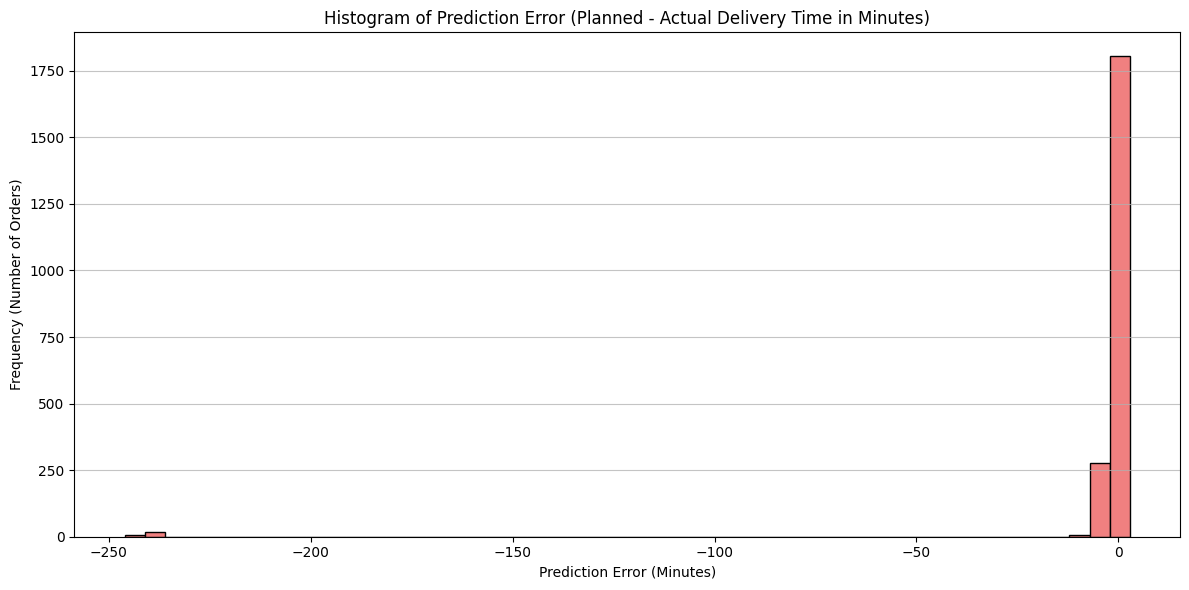


Descriptive Statistics of Prediction Error (Minutes):
count    2111.000000
mean       -2.797987
std        25.510344
min      -246.100000
25%        -1.150000
50%         0.350000
75%         1.366667
max         2.833333
Name: prediction_error_minutes, dtype: float64


In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd  # Make sure pandas is imported

# Ensure we have actual delivery duration
if 'actual_delivery_duration' in orders_with_actual_duration_df.columns and 'order_id' in orders_with_actual_duration_df.columns and 'planned_delivery_duration' in orders_df.columns:
    # Merge planned delivery duration if it's not already in the dataframe
    if 'planned_delivery_duration' not in orders_with_actual_duration_df.columns:
        orders_with_prediction_df = pd.merge(orders_with_actual_duration_df, orders_df[['order_id', 'planned_delivery_duration']], on='order_id', how='left')
    else:
        orders_with_prediction_df = orders_with_actual_duration_df.copy()

    # Calculate the prediction error (planned - actual) in minutes
    orders_with_prediction_df['prediction_error_minutes'] = (orders_with_prediction_df['planned_delivery_duration'] - orders_with_prediction_df['actual_delivery_duration']) / 60

    # Create the histogram of prediction error in minutes
    plt.figure(figsize=(12, 6))
    plt.hist(orders_with_prediction_df['prediction_error_minutes'].dropna(),
             bins=50,  # Adjust the number of bins as needed
             color='lightcoral',
             edgecolor='black')

    plt.title('Histogram of Prediction Error (Planned - Actual Delivery Time in Minutes)')
    plt.xlabel('Prediction Error (Minutes)')
    plt.ylabel('Frequency (Number of Orders)')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()

    # Print some descriptive statistics of the prediction error in minutes
    print("\nDescriptive Statistics of Prediction Error (Minutes):")
    print(orders_with_prediction_df['prediction_error_minutes'].describe())

else:
    print("Error: One or more of the required columns ('actual_delivery_duration', 'order_id', or 'planned_delivery_duration' in orders_df) not found.")

The prediction error (planned - actual delivery time) for 2111 orders reveals that, on average, our current system overestimates delivery time by approximately 2.8 minutes. However, the high standard deviation (around 25.5 minutes) indicates significant variability and imprecision in these predictions.

Notably, the minimum prediction error is around -246 minutes, directly reflecting the exceptionally long actual delivery times we previously identified as outliers. These outliers skew the overall error distribution and statistics. The majority of the prediction errors are likely clustered closer to zero, but the large negative outliers pull the mean downwards.

To better visualize the typical prediction error, we will focus on the bulk of the data by setting limits based on percentiles (e.g., the 1st to 99th percentile) to exclude these extreme outliers from the histogram. This will provide a clearer picture of the prediction error distribution for the majority of our deliveries. The substantial mean error and high standard deviation confirm that the current single-average prediction method is not very effective.

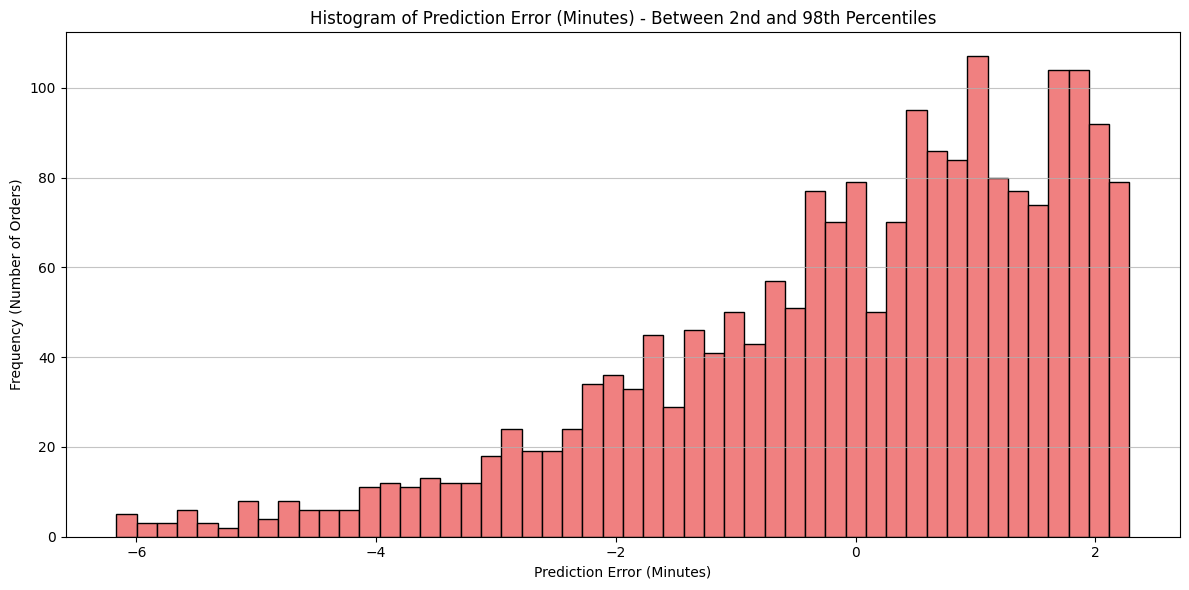


Prediction error range for the histogram: [-6.22, 2.28] minutes


In [25]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Ensure we have the prediction error in minutes
if 'prediction_error_minutes' in orders_with_prediction_df.columns:
    # Calculate the 2nd and 98th percentiles of the prediction error
    lower_bound = orders_with_prediction_df['prediction_error_minutes'].quantile(0.02)
    upper_bound = orders_with_prediction_df['prediction_error_minutes'].quantile(0.98)

    # Filter the data to include only values within the percentile range
    filtered_errors = orders_with_prediction_df[(orders_with_prediction_df['prediction_error_minutes'] >= lower_bound) &
                                                (orders_with_prediction_df['prediction_error_minutes'] <= upper_bound)]['prediction_error_minutes']

    # Create the histogram of the filtered prediction error
    plt.figure(figsize=(12, 6))
    plt.hist(filtered_errors.dropna(),
             bins=50,  # Adjust the number of bins as needed
             color='lightcoral',
             edgecolor='black')

    plt.title(f'Histogram of Prediction Error (Minutes) - Between 2nd and 98th Percentiles')
    plt.xlabel('Prediction Error (Minutes)')
    plt.ylabel('Frequency (Number of Orders)')
    plt.grid(axis='y', alpha=0.75)
    plt.tight_layout()
    plt.show()

    # Optionally, print the percentile bounds
    print(f"\nPrediction error range for the histogram: [{lower_bound:.2f}, {upper_bound:.2f}] minutes")

else:
    print("Error: 'prediction_error_minutes' column not found.")

Looking at the prediction error for most deliveries (excluding outliers), we see:

* **Slight Underestimation:** Planned times tend to be a bit shorter than actual times.
* **Still Variable:** Even for typical deliveries, the error can vary by several minutes.
* **More Often Under Than Over:** We're slightly more likely to underestimate.

This shows our current predictions aren't very accurate for most orders.

## Delivery Time Differences Across Sectors

To investigate if delivery times vary by geographic area, we grouped our data by `sector_id` and calculated the median actual delivery duration for each sector. We then visualized these differences using a bar chart (or box plots).



Number of valid deliveries before outlier filtering: 2111
Number of valid deliveries after outlier filtering (2nd to 98th percentile): 2026


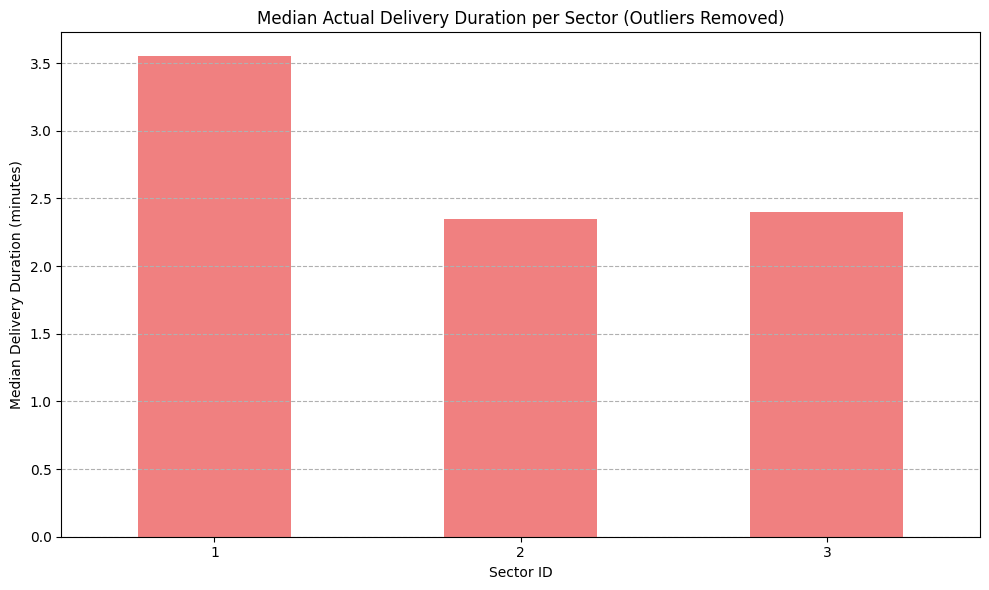


Median and Standard Deviation of Actual Delivery Duration per Sector (Outliers Removed):
            Median_Duration(min)  Std_Dev_Duration(min)
sector_id                                             
1                          3.55               2.055833
2                          2.35               1.390543
3                          2.40               1.428831


In [36]:
# Assuming you have already loaded your dataframes and executed the code you provided:
# orders_df, products_df, orders_products_df, route_segments_df
# and that orders_with_actual_duration_df is now available.

# Filter out rows where actual_delivery_duration is NaN (orders without STOP segments)
valid_deliveries_df = orders_with_actual_duration_df.dropna(subset=['actual_delivery_duration']).copy()

# Filter outliers based on actual delivery duration (2nd to 98th percentile)
lower_bound = valid_deliveries_df['actual_delivery_duration'].quantile(0.02)
upper_bound = valid_deliveries_df['actual_delivery_duration'].quantile(0.98)
filtered_errors_df = valid_deliveries_df[(valid_deliveries_df['actual_delivery_duration'] >= lower_bound) & (valid_deliveries_df['actual_delivery_duration'] <= upper_bound)].copy()

print(f"Number of valid deliveries before outlier filtering: {len(valid_deliveries_df)}")
print(f"Number of valid deliveries after outlier filtering (2nd to 98th percentile): {len(filtered_errors_df)}")

# Calculate the median actual delivery duration per sector using the filtered data in minutes
sector_delivery_times_filtered_median = filtered_errors_df.groupby('sector_id')['actual_delivery_duration'].median()/60.

# Calculate the standard deviation of actual delivery duration per sector
sector_delivery_times_filtered_std = filtered_errors_df.groupby('sector_id')['actual_delivery_duration'].std() / 60.    

# Create a bar chart
plt.figure(figsize=(10, 6))
sector_delivery_times_filtered.plot(kind='bar', color='lightcoral')
plt.title('Median Actual Delivery Duration per Sector (Outliers Removed)')
plt.xlabel('Sector ID')
plt.ylabel('Median Delivery Duration (minutes)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()

# Print the median and standard deviation per sector below the plot
sector_stats = pd.DataFrame({
    'Median_Duration(min)': sector_delivery_times_filtered_median,
    'Std_Dev_Duration(min)': sector_delivery_times_filtered_std
})
print("\nMedian and Standard Deviation of Actual Delivery Duration per Sector (Outliers Removed):\n", sector_stats)

Visualizing delivery times by sector shows clear differences:

* **Sector 1:** Takes longer on average, with some deliveries taking significantly longer than in other sectors.
* **Sector 2:** Generally has quicker deliveries with less variation in the typical delivery time.
* **Sector 3:** Also tends to be faster than Sector 1, with a similar spread to Sector 2.

This suggests that location (sector) does indeed impact delivery time, supporting the drivers' observations that not all areas are the same.

## What additional data would be worth collecting?

4.1. We can investigate if what's in the order affects delivery time. We'll look at:

* **Total weight:** How heavy the order is.
* **Total items:** How many items are in the order.
* **Unique products:** How many different types of items are in the order.

By combining order and product information, we can create charts (scatter plots or hexbin plots) to see if heavier orders or those with more items tend to take longer to deliver, likely due to handling.

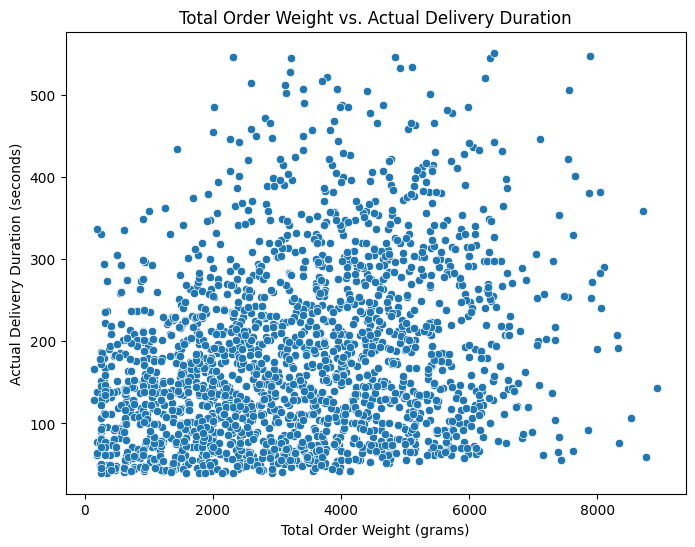

Pearson correlation coefficient between Total Order Weight and Actual Delivery Duration: 0.277


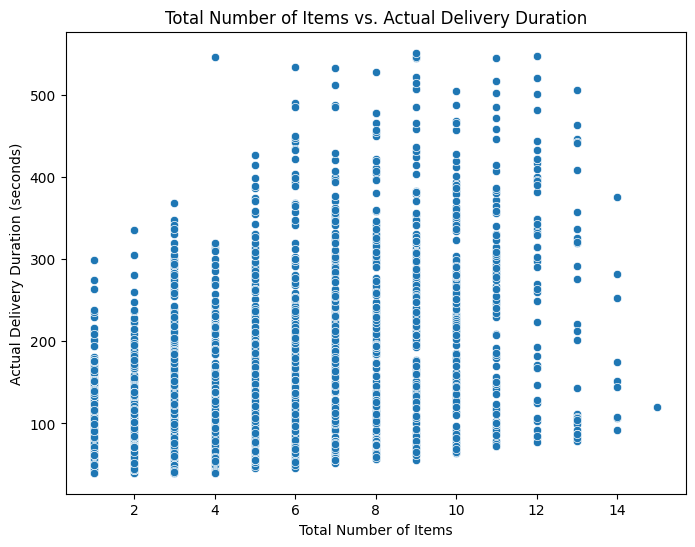

Pearson correlation coefficient between Total Number of Items and Actual Delivery Duration: 0.380


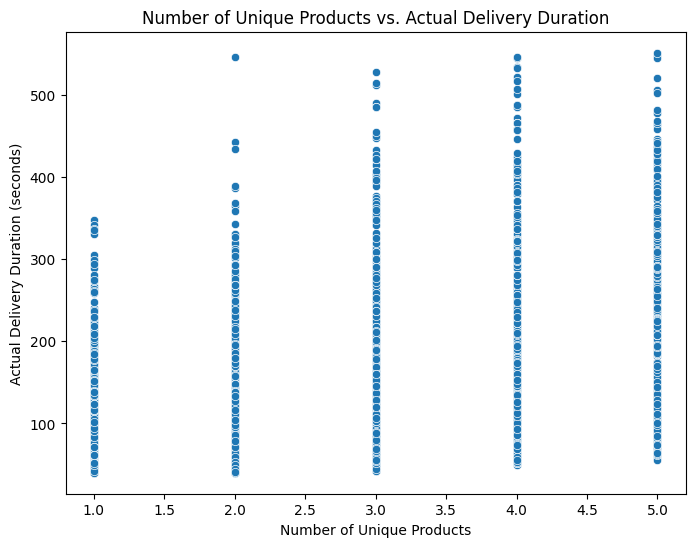

Pearson correlation coefficient between Count of Distinct product_id and Actual Delivery Duration: 0.321


In [48]:
# Merge necessary dataframes
orders_products_details_df = pd.merge(orders_products_df, products_df, on='product_id')
orders_with_product_info_df = pd.merge(orders_with_actual_duration_df, orders_products_details_df, on='order_id', how='left')

# Calculate aggregated order features
order_features_df = orders_with_product_info_df.groupby('order_id').agg(
    total_weight=('weight', 'sum'),
    total_quantity=('quantity', 'sum'),
    unique_products=('product_id', 'nunique')
).reset_index()

# Merge back into the main dataframe
final_df = pd.merge(filtered_errors_df, order_features_df, on='order_id', how='left')

# --- Visualizations ---
plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_df, x='total_weight', y='actual_delivery_duration')
plt.title('Total Order Weight vs. Actual Delivery Duration')
plt.xlabel('Total Order Weight (grams)')
plt.ylabel('Actual Delivery Duration (seconds)')
plt.show()

# Assuming your DataFrame with total_weight and actual_delivery_duration is named 'final_df'
correlation = final_df['total_weight'].corr(final_df['actual_delivery_duration'])
print(f"Pearson correlation coefficient between Total Order Weight and Actual Delivery Duration: {correlation:.3f}")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_df, x='total_quantity', y='actual_delivery_duration')
plt.title('Total Number of Items vs. Actual Delivery Duration')
plt.xlabel('Total Number of Items')
plt.ylabel('Actual Delivery Duration (seconds)')
plt.show()

# Assuming your DataFrame with total_quantity and actual_delivery_duration is named 'final_df'
correlation_items = final_df['total_quantity'].corr(final_df['actual_delivery_duration'])
print(f"Pearson correlation coefficient between Total Number of Items and Actual Delivery Duration: {correlation_items:.3f}")

plt.figure(figsize=(8, 6))
sns.scatterplot(data=final_df, x='unique_products', y='actual_delivery_duration')
plt.title('Number of Unique Products vs. Actual Delivery Duration')
plt.xlabel('Number of Unique Products')
plt.ylabel('Actual Delivery Duration (seconds)')
plt.show()

# Assuming your DataFrame with unique_products and actual_delivery_duration is named 'final_df'
correlation_items = final_df['unique_products'].corr(final_df['actual_delivery_duration'])
print(f"Pearson correlation coefficient between Count of Distinct product_id and Actual Delivery Duration: {correlation_items:.3f}")

Our analysis of order weight, total number of items, and the number of unique products reveals only weak to moderate positive correlations with delivery time.

* **Weight:** Shows a negligible linear relationship with how long deliveries take. Heavier orders don't consistently mean longer deliveries.
* **Number of Items:** Has a slightly stronger positive link (correlation of 0.38), suggesting more items tend to lead to slightly longer deliveries, but it's not a strong predictor on its own.
* **Unique Products:** Also shows a weak positive correlation (0.321). Orders with more variety of items tend to take a bit longer, but this isn't a major factor.

In short, what's in the order seems to have a limited direct impact on delivery time compared to other factors we've explored like location and time.

4.2. We also looked at whether *when* a delivery happens matters. We can analyze delivery times based on:

* **Hour of the day:** To see if rush hour or other times lead to longer deliveries.
* **Day of the week:** To check for weekday vs. weekend differences.

By looking at average or median delivery times for each hour and day, we can spot potential trends related to traffic or order volume.

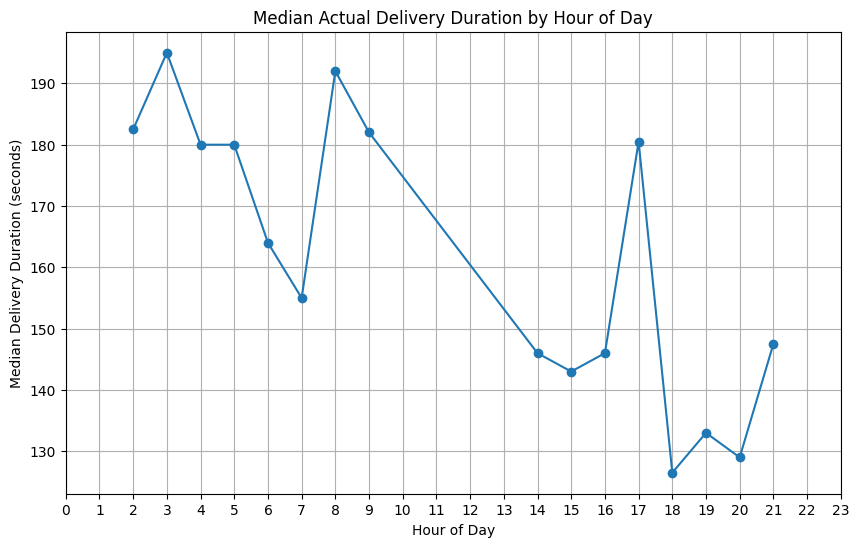

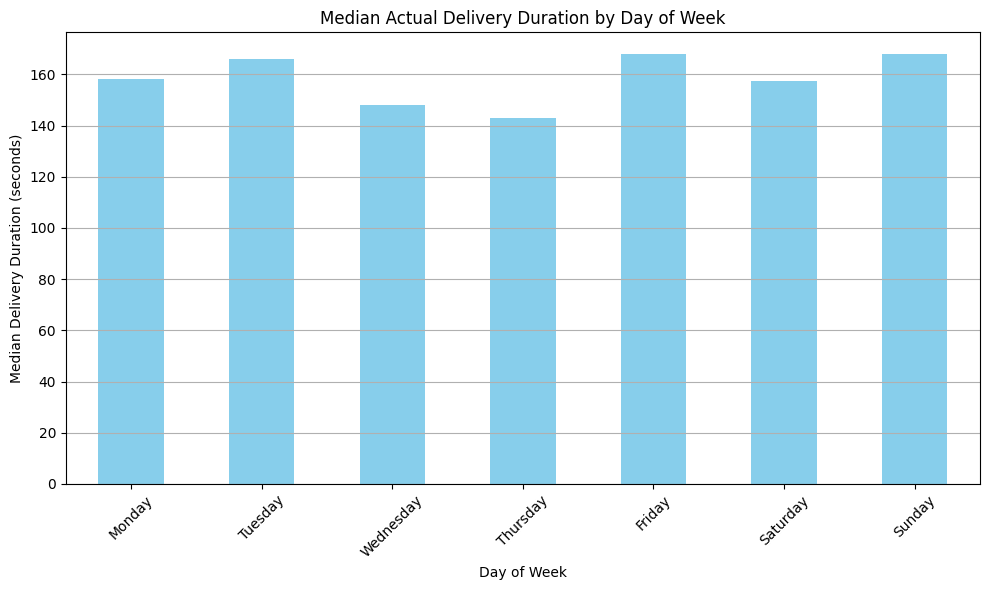

In [38]:
# Merge with stop segments to get start time
temporal_df = pd.merge(filtered_errors_df, stop_segments_df[['order_id', 'segment_start_time']], on='order_id', how='left')

# Extract temporal features
temporal_df['delivery_hour'] = temporal_df['segment_start_time'].dt.hour
temporal_df['delivery_day_of_week'] = temporal_df['segment_start_time'].dt.day_name()

# Aggregate by hour
hourly_delivery_times = temporal_df.groupby('delivery_hour')['actual_delivery_duration'].median()

# Aggregate by day of week (order the days)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_delivery_times = temporal_df.groupby('delivery_day_of_week')['actual_delivery_duration'].median().reindex(day_order)

# --- Visualizations ---
plt.figure(figsize=(10, 6))
hourly_delivery_times.plot(kind='line', marker='o')
plt.title('Median Actual Delivery Duration by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Median Delivery Duration (seconds)')
plt.xticks(range(24))
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
daily_delivery_times.plot(kind='bar', color='skyblue')
plt.title('Median Actual Delivery Duration by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Median Delivery Duration (seconds)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Looking at delivery times by the hour, we see a clear pattern:

* **Peaks:** Deliveries tend to take longer in the early morning and again in the late afternoon (around rush hour).
* **Dips:** Midday and late night/early morning see the fastest delivery times.

This strong link between the time of day and delivery duration means we should definitely consider the hour of delivery when making predictions. The relationship isn't simple, so we might need more advanced prediction methods to capture these ups and downs.
We can explore further how these hourly trends interact with other factors such as the delivery sector or the day of the week.

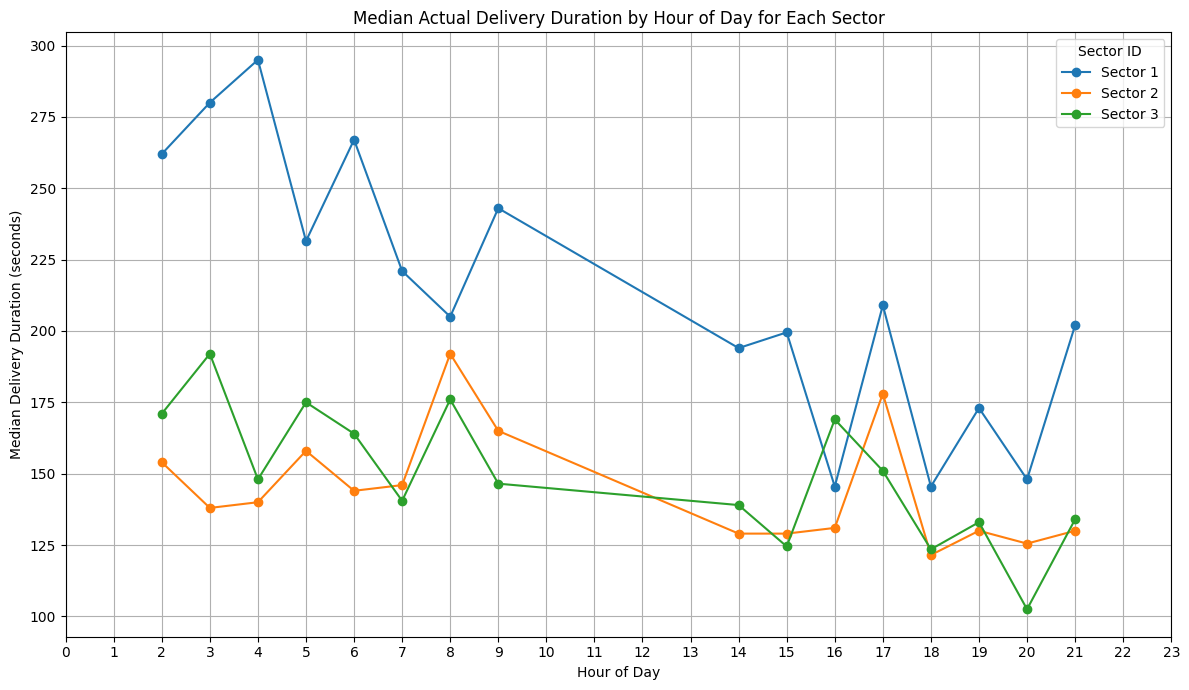

In [45]:
# Assuming filtered_errors_df has 'order_id', 'sector_id', and 'actual_delivery_duration'
# Assuming stop_segments_df has 'order_id' and 'segment_start_time'

# Merge the dataframes
hourly_sector_df = pd.merge(filtered_errors_df, stop_segments_df[['order_id', 'segment_start_time']], on='order_id', how='left')

# Extract the hour of the day
hourly_sector_df['delivery_hour'] = hourly_sector_df['segment_start_time'].dt.hour

# Group by sector and hour, and calculate the median delivery duration
median_duration_hourly_sector = hourly_sector_df.groupby(['sector_id', 'delivery_hour'])['actual_delivery_duration'].median().unstack()

# --- Visualization: Line Plot for Each Sector ---
plt.figure(figsize=(12, 7))
for sector in median_duration_hourly_sector.index:
    plt.plot(median_duration_hourly_sector.columns, median_duration_hourly_sector.loc[sector], marker='o', label=f'Sector {sector}')

plt.title('Median Actual Delivery Duration by Hour of Day for Each Sector')
plt.xlabel('Hour of Day')
plt.ylabel('Median Delivery Duration (seconds)')
plt.xticks(range(24))
plt.legend(title='Sector ID')
plt.grid(True)
plt.tight_layout()
plt.show()


When we look at how delivery times change throughout the day *within each sector*, we see different patterns:

* **Sector 1:** Has big swings, with longer deliveries in the early morning and late afternoon/early evening.
* **Sector 2:** Is more stable, with a peak around morning commute time.
* **Sector 3:** Is slowest very early in the morning but generally the fastest during the day.

This shows that the best prediction will consider *both* the time of day and the delivery location (sector). For further analysis it would be beneficial to check causes of these unique patterns in each area (traffic, order volume, building types etc.).

4.3 Do Some Drivers Deliver Faster Than Others?

We also explored if individual drivers have different average delivery times. By looking at the median delivery time for each driver, we can see if some are consistently quicker or slower than others.

We need to keep in mind that differences in driver speeds might not just be about the driver themselves. They could be influenced by the areas they usually deliver to or the types of orders they handle most often.

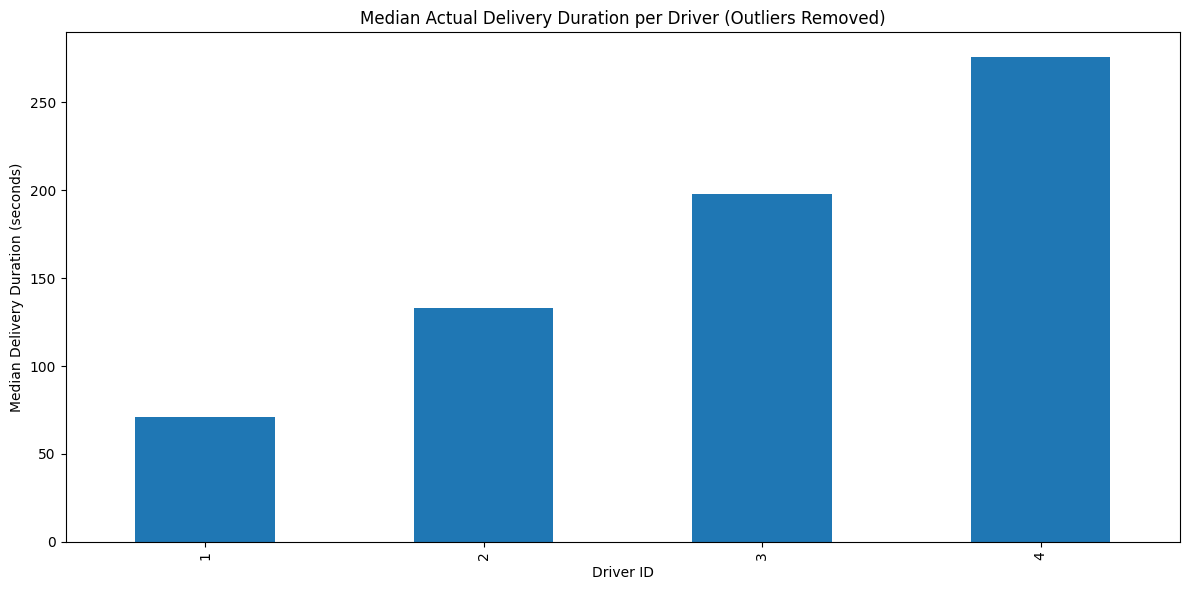

In [40]:
# Merge with stop segments to get driver ID
driver_delivery_df = pd.merge(filtered_errors_df, stop_segments_df[['order_id', 'driver_id']], on='order_id', how='left')

# Calculate median delivery time per driver
driver_delivery_times = driver_delivery_df.groupby('driver_id')['actual_delivery_duration'].median()

# --- Visualization ---
plt.figure(figsize=(12, 6))
driver_delivery_times.sort_values().plot(kind='bar')
plt.title('Median Actual Delivery Duration per Driver (Outliers Removed)')
plt.xlabel('Driver ID')
plt.ylabel('Median Delivery Duration (seconds)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Looking at the median delivery times for different drivers, we see clear differences. Some drivers consistently complete deliveries faster than others.

This suggests that *who* is making the delivery is another important factor in how long it takes. To make better predictions, we should consider the driver's ID. However, we need to be careful – faster or slower times could be due to the areas they usually work in or the types of deliveries they handle. Understanding these reasons could help us improve our predictions and even our operations.

Number of deliveries per driver per sector:
     driver_id  sector_id  delivery_count
0           1          1             190
1           1          2             133
2           1          3             173
3           2          1             167
4           2          2             171
5           2          3             156
6           3          1             167
7           3          2             185
8           3          3             193
9           4          1             149
10          4          2             178
11          4          3             179


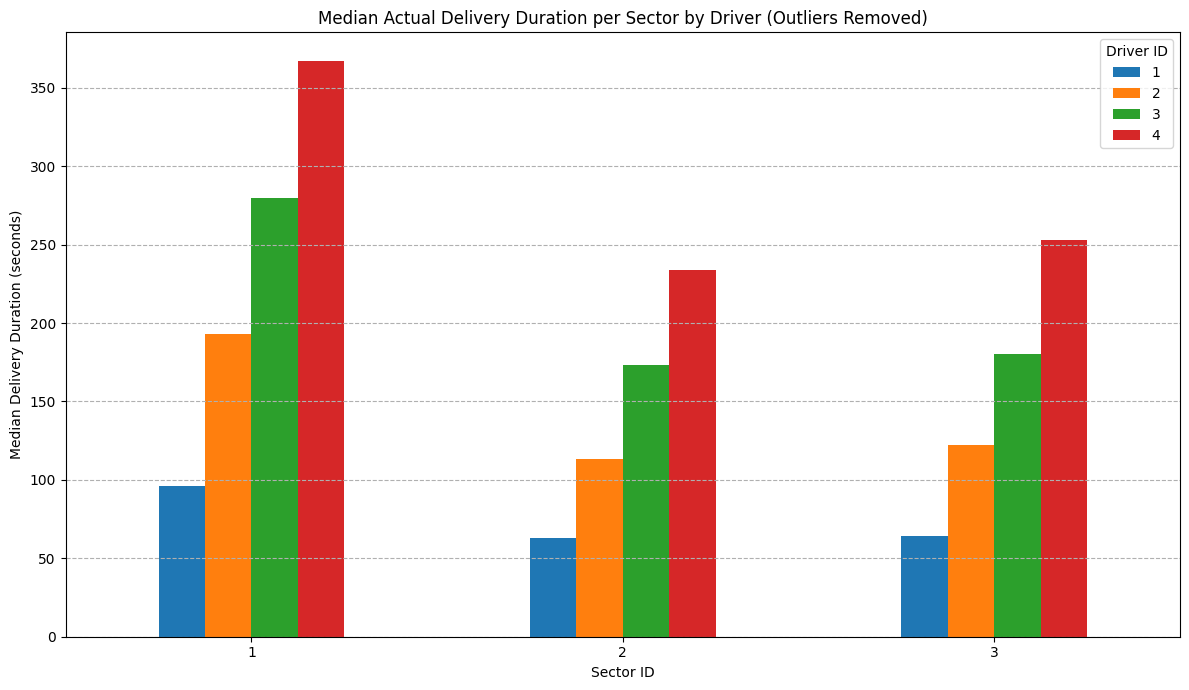

In [43]:
# Assuming filtered_errors_df has 'order_id', 'actual_delivery_duration', and 'sector_id'
# and stop_segments_df has 'order_id' and 'driver_id'

# Merge filtered delivery times with driver information
driver_sector_df = pd.merge(filtered_errors_df, stop_segments_df[['order_id', 'driver_id']], on='order_id', how='left')

# Remove rows with NaN in driver_id (if any STOP segment didn't have a driver)
driver_sector_df_cleaned = driver_sector_df.dropna(subset=['driver_id']).copy()

# Analyze driver distribution across sectors
driver_sector_counts = driver_sector_df_cleaned.groupby(['driver_id', 'sector_id']).size().reset_index(name='delivery_count')
print("Number of deliveries per driver per sector:\n", driver_sector_counts)

# Visualize median delivery times per driver per sector using a grouped bar chart
sector_driver_median_times = driver_sector_df_cleaned.groupby(['sector_id', 'driver_id'])['actual_delivery_duration'].median().unstack()
sector_driver_median_times.plot(kind='bar', figsize=(12, 7))
plt.title('Median Actual Delivery Duration per Sector by Driver (Outliers Removed)')
plt.xlabel('Sector ID')
plt.ylabel('Median Delivery Duration (seconds)')
plt.xticks(rotation=0)
plt.legend(title='Driver ID')
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()


When we compare driver speeds *within* each delivery area (sector), we see interesting patterns:

* **Consistent Fast/Slow Drivers:** Some drivers (like Driver 1) tend to be faster across all sectors, while others (like Driver 4) are consistently slower. This reinforces that the driver matters.
* **Sectors Have Different Difficulties:** Deliveries in Sector 1, as seen earlier, generally take longer for all drivers, suggesting this area might be inherently more challenging.
* **Driver Performance Varies by Sector:** While some drivers are generally faster, their advantage might be bigger in certain areas.

This means to really nail our predictions, we need to consider not just *who* is delivering, but *where* they are delivering. Our prediction tools should probably learn these driver-location combinations.